# sivtempfit tutorial 

**Author**: [Ruffin Evans](mailto:ruffinevans@gmail.com)

This notebook is a brief introduction to doing Bayesian inference on fluorescence spectra of SiV centers in diamond. So far, the package supports two models:

1. One-peak model: a broad Lorentzian peak for the SiV
2. Two-peak model: a broad Lorentzian for the SiV and a narrow Lorentzian for the calibration laser.

The package is designed to read in fluorescence spectra in the format returned by our instrument (or work with a generic `pandas` dataframe object) and then use the `emcee` package to sample the posterior distribution of model parameters given the data.

## Getting started
First, import the package. This assumes that the package is already downloaded and installed.

If you need to download and install the package, please see the readme on the [github page](https://github.com/ruffinevans/sivtempfit).

In [1]:
import sivtempfit as stf
import sivtempfit.io as io
import sivtempfit.inferMC as mc
import sivtempfit.model as model
from sivtempfit.dataprocessing import Spectrum

We will also import a few other fairly standard packages to assist us. All of these packages are requirements for `sivtempfit`, so you should have them installed if the installation of the `sivtempfit` package went well.

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import emcee
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")

We'll also use the [`corner` package](http://corner.readthedocs.io/en/stable/) to make some nice plots. If you can't (or don't want to) install this package, you can use `sns.pairplot` as a replacement.

In [3]:
from corner import corner

## Importing data and the `Spectrum` object

In general, you will have some experimental data that consists of one-dimensional fluorescence spectra, i.e. fluorescence intensity or counts as a function of wavelength.

The package includes support for data in a simple `[x, y]` format where `x` is a numpy array of the x values and `y` is a numpy array of the y values.

The package also defines and includes support for a `Spectrum` object, which is basically just a pandas dataframe with a `metadata` dict bolted onto it. The `sivtempfit.io` module includes some utilities to import these `Spectrum` objects, and the `Spectrum` object itself supports json output through the `write_json` method.

Finally, the package supports reading in the strange `csv` files created by our data acquisition software, including for multi-acquisition experiments.

We'll use such a `Spectrum` object in this tutorial. These objects can be instantiated as `Spectrum(DataFrame, metadata)` where `DataFrame` is the spectrum data as a `pandas` `DataFrame` and `metadata` is a dict of anything else that you want to use to describe the spectrum.

For the purposes of this tutorial, let's import some example data (included with the package.) To do this, we will use the `io` module to create a `Spectrum` object. `Spectrum` objects are natively stored as `json`.

In [4]:
path_to_json = io.get_example_data_file_path("test_experimental_spectrum.json")
loaded_spectrum = io.load_Spectrum(path_to_json)

Now, `test_spectrum` is a `Spectrum` object that has both data and metadata. We can examine both:

In [5]:
loaded_spectrum.data[:10]

,counts,wavelength
0,1157,730.7841
1,1161,730.7931
10,1170,730.8741
100,1168,731.6841
1000,1543,739.7841
1001,1540,739.7931
1002,1562,739.8021
1003,1550,739.8111
1004,1539,739.8201
1005,1589,739.8291


In [6]:
loaded_spectrum.metadata

{'Laser Frequency': '401.496 THz',
 'Name': 'Example spectrum of an SiV plus a laser calibration line taken at 300K.'}

We can also import the files created by the Horiba multi-acquisition DAQ software, in which case a list of `Spectrum` objects is returned. The header with the list of separate temperatures is automatically stripped away and stored in the metadata of each `Spectrum` object.

In [7]:
path_to_data = io.get_example_data_file_path("varying acquisition time horiba.txt")
spectra_multi = io.import_horiba_multi(path_to_data)

As promised, we can see that the metadata are indeed different for each spectrum.

In [8]:
spectra_multi[0].metadata

{'File creation time': 1462463553.1537216,
 'Original file path': 'C:\\Users\\Ruffin\\Dropbox (Lukin SiV)\\Harvard Physics\\Classes\\PHYS 201\\Project\\project code\\sivtempfit\\exampledata\\varying acquisition time horiba.txt',
 'Temperature': 331.0}

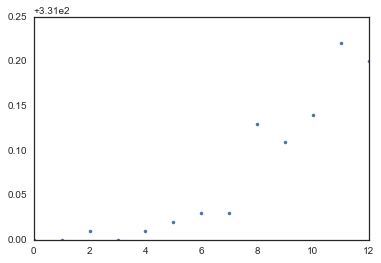

In [9]:
plt.plot([x.metadata['Temperature'] for x in spectra_multi], ".")

It is also possible to include additional metadata during import. A list of dicts can also be added if each spectrum should have different attributes.

In [10]:
spectra_multi = io.import_horiba_multi(path_to_data, metadata={'Purpose': 'Demonstrate io for tutorial'})

The metadata is appended to each spectrum. Metadata can be manually added to a spectrum using the `add_to_metadata` method of the `Spectrum` object.

In [11]:
spectra_multi[0].metadata

{'File creation time': 1462463553.1537216,
 'Original file path': 'C:\\Users\\Ruffin\\Dropbox (Lukin SiV)\\Harvard Physics\\Classes\\PHYS 201\\Project\\project code\\sivtempfit\\exampledata\\varying acquisition time horiba.txt',
 'Purpose': 'Demonstrate io for tutorial',
 'Temperature': 331.0}

## Visualize the example data

Let's visualize the example data. Here, let's work with the first element of that temperature data.

In [12]:
test_spectrum = spectra_multi[0]

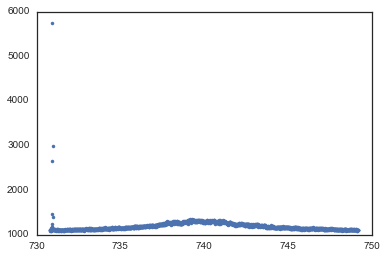

In [13]:
plt.plot(test_spectrum.data['xdata'], test_spectrum.data['ydata1'], ".")

## Set up the model and MC sampling to perform inference

We have a model for this function that includes two lorentzian peaks plus gaussian background noise. The model is described in the likelihood function. There are two options:

In [14]:
print(model.one_peak_log_likelihood.__doc__)


    Returns the log-likelihood calculated for the two-peak + CCD noise model.
    See also: one_peak_model
    Parameters:
    -----------
    x : wavelength or x-axis value
    y : corresponding observed data value
    amp: amplitude of the SiV peak in the spectrum
    T : The temperature of the sample
    m : The linear scaling of the SiV peak position with temperature
    C0 : The offset in the above linear scaling
    width : The width (FWHM) of the SiV line
    light_background : The contribution to the background from stray light,
                       contributing shot noise
    ccd_backgrond : The contribution to the background from CCD readout,
                    contributing gaussian noise
    ccd_stdev : The standard deviation on the gaussian CCD noise

    Optional Arguments:
    -------------------
    gaussian_approx: Use a gaussian approximation for the poisson distribution.
                     This allows the calculation to be sped up by several
                    

In [15]:
print(model.two_peak_log_likelihood.__doc__)


    Returns the log-likelihood calculated for the two-peak + CCD noise model.
    See also: two_peak_model
    Parameters:
    -----------
    x : wavelength or x-axis value
    y : corresponding observed data value
    amp1 : amplitude of the broad SiV peak in the spectrum
    amp2 : amplitude of the narrow calibration peak in the spectrum
    T : The temperature of the sample
    m : The linear scaling of the SiV peak position with temperature
    C0 : The offset in the above linear scaling
    center2 : The position of the calibration line
    width1 : The width (FWHM) of the SiV line
    width2 : The width (FWHM) of the calibration line
    light_background : The contribution to the background from stray light,
                       contributing shot noise
    ccd_backgrond : The contribution to the background from CCD readout,
                    contributing gaussian noise
    ccd_stdev : The standard deviation on the gaussian CCD noise

    Optional Arguments:
    ------------

We would like to determine the parameters of the model that fit the data. To do this, we will do Bayesian parameter estimation by sampling the likelihood function using the [`emcee` Monte-Carlo sampler](http://dan.iel.fm/emcee/current/).

The first step is to generate a set of starting points for the sampling; here, we will use an `emcee` `sample_ball` object. **This is normally done automatically in the course of evaluating `mc_likelihood_sampler`** but can also be done manually (and then passed to the `mc_likelihood_sampler`) for more fine-grained control. Even though it's normally not necessary, I will demonstrate the usage here.

Here is an example of the guesses. (Normally, `debug` should be set to `False` to generate the object; when it is `True`, it outputs the values instead.)

For more information, see the `generate_sample_ball` documentation. In particular, note that some guess (it can be any number) is required for the second argument of generate_sample_ball. This is important for the two-peak case (more on this in a moment) but irrelevant for the one-peak case.

In [16]:
print(mc.generate_sample_ball(test_spectrum, 731, num_peaks = 1, debug = True))

((2125.4400000000001, 740, 7.2, 3.3330000000000002, 1055.45, 10), (42.508800000000001, 0.015, 0.2, 66.659999999999997, 52.772500000000008, 4.0))


We can also visualize the model prediction based on the parameters at the center of the sample ball:

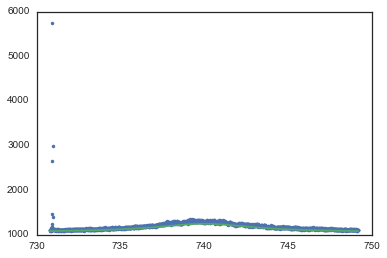

In [17]:
plt.plot(test_spectrum.data['xdata'], test_spectrum.data['ydata1'], ".")
plt.plot(test_spectrum.data['xdata'], mc.generate_sample_ball(test_spectrum, 730.9, 1, return_y_values=True), "-")

To fit the single-peak model, let's make a new `Spectrum` object from the old one that has the first peak removed. This is important, because the pixels in the first peak can mess up the fit.

In [18]:
test_spectrum_reduced = Spectrum(test_spectrum.data[100:],test_spectrum.metadata)

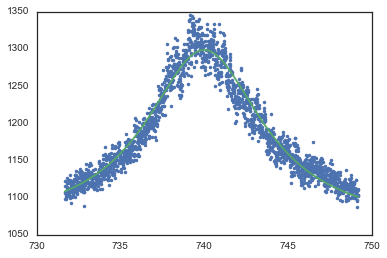

In [19]:
plt.plot(test_spectrum_reduced.data['xdata'], test_spectrum_reduced.data['ydata1'], ".")
plt.plot(test_spectrum_reduced.data['xdata'], mc.generate_sample_ball(test_spectrum_reduced, 730.9, 1, return_y_values=True), "-")

As you can see, the default guess is pretty decent, but not perfect. Above, we have constructed a sample ball to fit the single-peak case, and you can see that the calibration peak is not covered at all. Because the calibration peak is very sharp, the likelihood for the center position should also be very sharply peaked. So, if we want to look at the two-peak case, let's do as well as we can to guess the position of this calibration peak:

In [20]:
calib_pos_guess = test_spectrum.data['xdata'][np.argmax(test_spectrum.data['ydata1'])]
calib_pos_guess

730.93709999999999

Now we can construct a sample ball for the two peak case. Note that the only difference is that num_peaks is 2.

In [21]:
print(mc.generate_sample_ball(test_spectrum, 731, num_peaks = 2, debug = True))

((2125.4400000000001, 78.461549999999988, 9, 731, 7.2, 0.0113, 3.3330000000000002, 1055.45, 10), (42.508800000000001, 1.5692309999999998, 0.015, 0.00015, 0.2, 0.0005, 66.659999999999997, 52.772500000000008, 4.0))


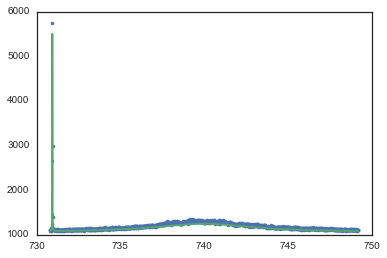

In [22]:
plt.plot(test_spectrum.data['xdata'], test_spectrum.data['ydata1'], ".")
plt.plot(test_spectrum.data['xdata'], mc.generate_sample_ball(test_spectrum, calib_pos_guess, 2, return_y_values=True), "-")

Note how above, the sharp calibration peak is now in the model and the model has more parameters accordingly.

## Setting up and running the `emcee` sampler

Now, we can run the emcee sampler by calling the `mc_likelihood_sampler` function. which takes as mandatory arguments the data (in either `[x_array, y_array]` form or in the form of a `Spectrum` object), the expected position of the calibration peak, and the model to fit (either one peak or two peaks). By default, it runs the sampler right away. This can be disabled with the `run = False` kwarg. 

There are lots of possible arguments to pass to this function, but perhaps the most important is the `gaussian_approx` keyword. By default, the sampler calculates the posterior using a mixed Poisson-Gaussian likelihood (see the `model_development` notebook for more information). This is more accurate for small numbers of photons, but almost three orders of magnitude slower than simply approximating the Poisson noise as Gaussian. Under most circumstances, setting `gaussian_approx=True` is OK. For the sake of time, let's do it here.

Define and run the sampler. If the default sample ball is bad (i.e. the guess for the parameters is bad), you can pass in a better one using the `starting_pos` argument as described in the docstring.

First, let's make and run a sampler for the model with a single peak only. This should take a minute or two.

In [45]:
%time test_sampler_1 = mc.mc_likelihood_sampler(test_spectrum_reduced, calib_pos_guess, num_peaks=1, nwalkers=64, nsteps=2000, threads=1, gaussian_approx=True)

Wall time: 43.2 s


Let's also make and run a sampler for the model that contains two peaks. This should also take a minute or two.

In [46]:
%time test_sampler_2 = mc.mc_likelihood_sampler(test_spectrum, calib_pos_guess, num_peaks=2, nwalkers=64, nsteps=2000, threads=1, gaussian_approx=True)

Wall time: 44.1 s


## Extract results from the `emcee` sampler

Let's look at the results for the one-peak model and the two-peak model separately. The way to analyze the results from the two is almost exactly the same, so I'll go through the one-peak model carefully and then go quickly through the two-peak model.

### One-peak results

Let's look at the traces to estimate the burn-in time. You should always do this when you start working on a new dataset to make sure the sampler is doing the right thing. This plotting command actually takes quite a bit of time (also a minute or two), so please be patient.

[ 0.39414634  0.30829268  0.32780488  0.31804878  0.32195122  0.35804878
  0.3         0.          0.32146341  0.3604878   0.          0.32731707
  0.29317073  0.2697561   0.33853659  0.3395122   0.34097561  0.35804878
  0.34536585  0.31658537  0.36195122  0.36292683  0.36780488  0.32878049
  0.35073171  0.34682927  0.35414634  0.31560976  0.33512195  0.3595122
  0.30780488  0.26195122  0.32487805  0.35902439  0.38097561  0.32926829
  0.30292683  0.          0.3497561   0.          0.3804878   0.38780488
  0.38292683  0.          0.38634146  0.37560976  0.35219512  0.37365854
  0.34146341  0.37073171  0.27756098  0.37804878  0.3195122   0.32731707
  0.34195122  0.36634146  0.3497561   0.32195122  0.36341463  0.39902439
  0.32097561  0.32829268  0.37073171  0.26487805]
[ 67.15822706  87.66906388  80.16696651  93.03178501  92.23686738
  93.73495134]


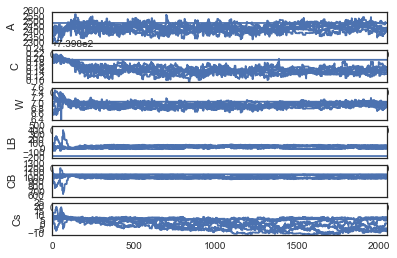

In [47]:
fig, (ax_amp, ax_c, ax_width, ax_lb, ax_ccdb, ax_ccds) = plt.subplots(6)
ax_amp.set(ylabel='A')
ax_c.set(ylabel='C')
ax_width.set(ylabel='W')
ax_lb.set(ylabel='LB')
ax_ccdb.set(ylabel='CB')
ax_ccds.set(ylabel='Cs')
for i in range(9):
    sns.tsplot(test_sampler_1.chain[i,:,0], ax=ax_amp)
    sns.tsplot(test_sampler_1.chain[i,:,1], ax=ax_c)
    sns.tsplot(test_sampler_1.chain[i,:,2], ax=ax_width)
    sns.tsplot(test_sampler_1.chain[i,:,3], ax=ax_lb)
    sns.tsplot(test_sampler_1.chain[i,:,4], ax=ax_ccdb)
    sns.tsplot(test_sampler_1.chain[i,:,5], ax=ax_ccds)
print(test_sampler_1.acceptance_fraction)
print(test_sampler_1.acor)

Burn-in definitely seems to have occured by 1000 samples or so, probably earlier. In general, you don't need that many independent samples (the number of steps per independent "sample" is estimated by the correlation length) to reconstruct the posterior, so running 2500 steps here is probably overkill.

There are a few built-in utilities to help analyze this data. `parameter_samples_df` flattens the sampler chain and turns it into a pandas dataframe to aid plotting and analysis, and `credible_intervals_from_sampler` returns a set of credible intervals directly from the sampler. The docstrings for these functions describe their use.

For example, we can use such a dataframe to create a corner plot for the parameters. (If you don't like the corner plot, an alternative is to use `sns.pairplot`.)

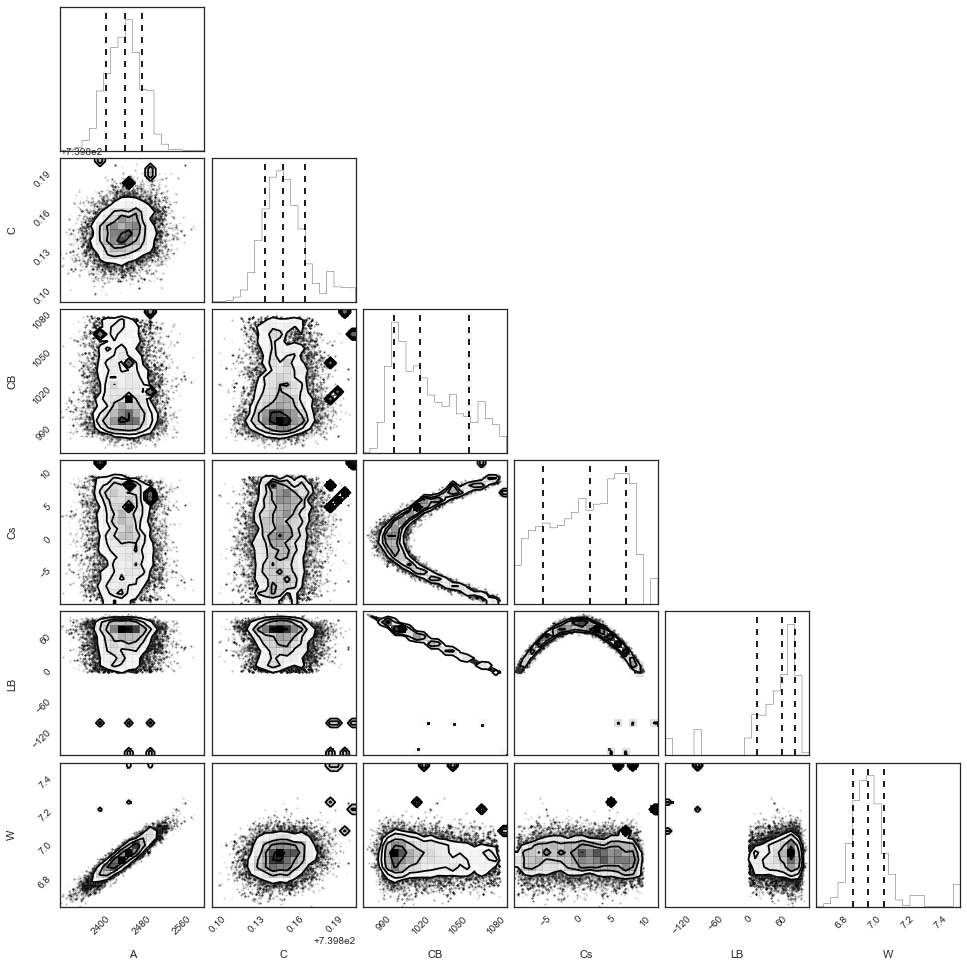

In [48]:
parameter_samples_1 = mc.parameter_samples_df(test_sampler_1, burn_in = 1000)
corner(parameter_samples_1, quantiles=[0.16, 0.5, 0.84]);

There's not much here worth commenting on except for the strangly shaped curves for the joint distribution between `cs` (the standard deviation of the CCD background noise) and `cb` (the extent of that background noise).

Because the noise is parameterized as Poisson + Gaussian noise, and because we are working in the gaussian approximation for the poisson noise, there is no difference between "blaming" some of the noise on the gaussian noise compared to the poisson noise. This can also be seen in the strong anticorrelation between the extent of the gaussian noise and the extent of the poisson noise. However, because physically the noise *is* shot noise, if the Gaussian part of the noise increases to account for the shot noise, the standard deviation must also increase as the square root of the extent of the noise. Because here the standard deviation is allowed to be positive or negative, there is (as we would hope) reflection symmetry around the $\sigma = 0$ plane.

The result that we care about the most is the predicted offset in the center position. This corresponds to the physical wavelength of the SiV center after accounting for the calibration laser position. So, let's plot the marginalized distribution for this parameter:

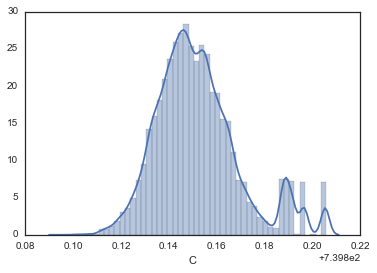

In [49]:
sns.distplot(parameter_samples_1['C'])

This looks pretty good -- fairly symmetric, and is centered more or less where we would expect. Any outliers to the right probably arise from the few walkers with zero acceptance fraction and can be removed by running with more walkers or refining the sample ball.

To be more quantitative, we can extract MAP 68% credible intervals for each parameter using the following command. Again, see the docstring for how this function can be used.

In [50]:
mc.credible_intervals_from_sampler(test_sampler_1, burn_in=1500, interval_range=[0.68, 0.95]);


For credibility level 0.680:
A = 2449.2703 + 32.1501 - 37.2209
C = 739.9498 + 0.0171 - 0.0145
CB = 1022.5223 + 40.1407 - 22.7192
Cs = 1.1720 + 5.9418 - 7.1014
LB = 57.6311 + 24.1091 - 46.1709
W = 6.9627 + 0.0916 - 0.0895

For credibility level 0.950:
A = 2449.2703 + 61.0463 - 68.2340
C = 739.9498 + 0.0466 - 0.0266
CB = 1022.5223 + 58.0735 - 32.0991
Cs = 1.1720 + 7.9874 - 10.0329
LB = 57.6311 + 33.7275 - 196.9846
W = 6.9627 + 0.5272 - 0.1712


If we'd like to store these results, we can add them back to the Spectrum object as metadata and then use all of the io functions to store and recall spectrum objects.

In [51]:
intervals = mc.credible_intervals_from_sampler(test_sampler_1, burn_in=1500, interval_range=0.68, print_out=False)
test_spectrum.add_to_metadata({"68% credible intervals" : intervals})

Make sure it worked:

In [52]:
test_spectrum.metadata

{'68% credible intervals': [[2449.2702914553579,
   32.150071164354813,
   37.220920355225189],
  [739.94978537265899, 0.017099947355063705, 0.014482019276897518],
  [1022.5222938894683, 40.140674684416581, 22.719200164402196],
  [1.1719747486646712, 5.9417875289784741, 7.1013612875240728],
  [57.631064736729776, 24.109063030023158, 46.170917725952812],
  [6.9627195699158779, 0.091604817789149529, 0.089488263884372365]],
 'File creation time': 1462463553.1537216,
 'Original file path': 'C:\\Users\\Ruffin\\Dropbox (Lukin SiV)\\Harvard Physics\\Classes\\PHYS 201\\Project\\project code\\sivtempfit\\exampledata\\varying acquisition time horiba.txt',
 'Purpose': 'Demonstrate io for tutorial',
 'Temperature': 331.0}

### Two-peak results

Again, plot the traces to make sure everything is OK.

[ 0.32292683  0.31512195  0.37317073  0.3297561   0.33463415  0.37073171
  0.34634146  0.33560976  0.33560976  0.30487805  0.34780488  0.26731707
  0.30487805  0.34243902  0.31268293  0.31707317  0.29658537  0.33707317
  0.          0.31560976  0.34878049  0.28341463  0.35853659  0.34341463
  0.33853659  0.29756098  0.34097561  0.34829268  0.34536585  0.35365854
  0.3102439   0.37268293  0.33902439  0.34390244  0.34878049  0.36487805
  0.35414634  0.3204878   0.32878049  0.31073171  0.34292683  0.32682927
  0.33560976  0.3302439   0.27463415  0.          0.33707317  0.28780488
  0.3102439   0.30585366  0.33414634  0.34341463  0.31317073  0.35219512
  0.33560976  0.28634146  0.33219512  0.32195122  0.3302439   0.28390244
  0.30682927  0.32634146  0.33365854  0.33512195]
[ 85.95005527  87.29255329  95.75172891  92.97893209  74.77524622
  73.2718211   78.40024877  80.94246246  87.45582979]


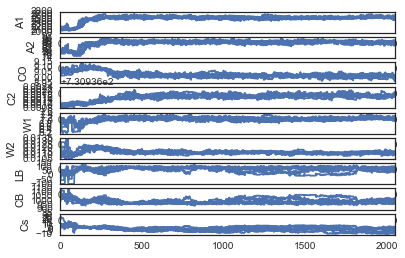

In [53]:
fig, (ax_amp1, ax_amp2, ax_c0, ax_center2, ax_width1, ax_width2, ax_lb, ax_ccdb, ax_ccds) = plt.subplots(9)
ax_amp1.set(ylabel='A1')
ax_amp2.set(ylabel='A2')
ax_c0.set(ylabel='CO')
ax_center2.set(ylabel='C2')
ax_width1.set(ylabel='W1')
ax_width2.set(ylabel='W2')
ax_lb.set(ylabel='LB')
ax_ccdb.set(ylabel='CB')
ax_ccds.set(ylabel='Cs')
for i in range(9):
    sns.tsplot(test_sampler_2.chain[i,:,0], ax=ax_amp1)
    sns.tsplot(test_sampler_2.chain[i,:,1], ax=ax_amp2)
    sns.tsplot(test_sampler_2.chain[i,:,2], ax=ax_c0)
    sns.tsplot(test_sampler_2.chain[i,:,3], ax=ax_center2)
    sns.tsplot(test_sampler_2.chain[i,:,4], ax=ax_width1)
    sns.tsplot(test_sampler_2.chain[i,:,5], ax=ax_width2)
    sns.tsplot(test_sampler_2.chain[i,:,6], ax=ax_lb)
    sns.tsplot(test_sampler_2.chain[i,:,7], ax=ax_ccdb)
    sns.tsplot(test_sampler_2.chain[i,:,8], ax=ax_ccds)
print(test_sampler_2.acceptance_fraction)
print(test_sampler_2.acor)

Create a pairplot for the parameters:

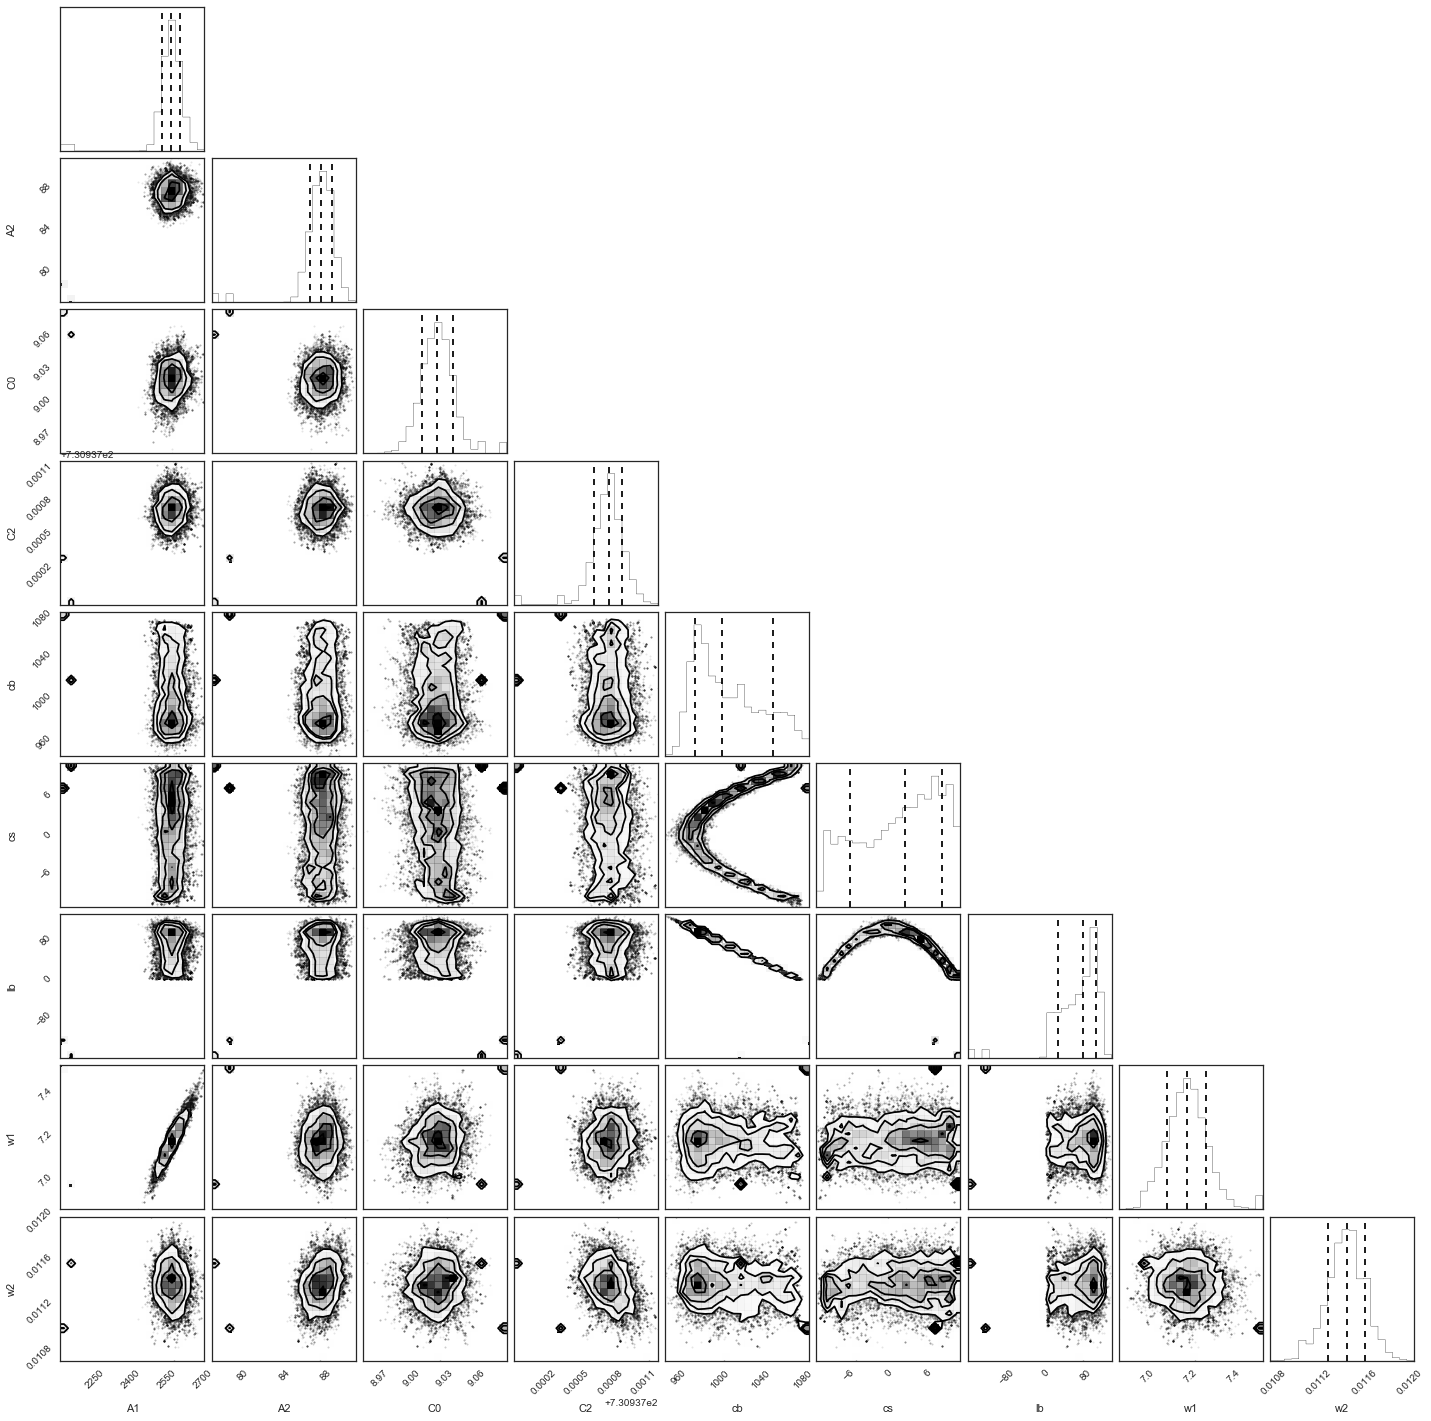

In [54]:
parameter_samples_2 = mc.parameter_samples_df(test_sampler_2, burn_in = 1500)
corner(parameter_samples_2, quantiles=[0.16, 0.5, 0.84]);

Looks great.

Again, look at the center positions:

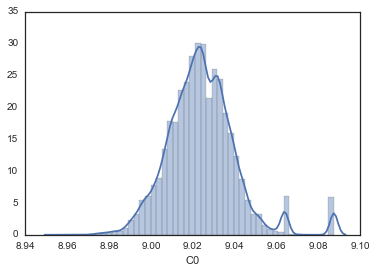

In [55]:
sns.distplot(parameter_samples_2['C0'])

Again, extract the MAP credible intervals:

In [56]:
mc.credible_intervals_from_sampler(test_sampler_2, burn_in=1500, interval_range=[0.68, 0.95]);


For credibility level 0.680:
A1 = 2569.2050 + 36.4725 - 39.4918
A2 = 87.5848 + 0.9844 - 1.1505
C0 = 9.0235 + 0.0143 - 0.0142
C2 = 730.9378 + 0.0001 - 0.0001
cb = 1002.3143 + 48.4651 - 26.0410
cs = 2.4888 + 5.5478 - 8.3944
lb = 74.2551 + 26.2152 - 51.5555
w1 = 7.1814 + 0.0911 - 0.0909
w2 = 0.0114 + 0.0002 - 0.0002

For credibility level 0.950:
A1 = 2569.2050 + 77.0404 - 423.9122
A2 = 87.5848 + 1.9595 - 8.8627
C0 = 9.0235 + 0.0405 - 0.0286
C2 = 730.9378 + 0.0003 - 0.0005
cb = 1002.3143 + 72.5843 - 38.0366
cs = 2.4888 + 7.7027 - 12.0160
lb = 74.2551 + 38.0472 - 202.0268
w1 = 7.1814 + 0.2045 - 0.1821
w2 = 0.0114 + 0.0003 - 0.0004


### Compare the two-peak and the one-peak results

For the one-peak results, we have:

In [57]:
intervals_1 = mc.credible_intervals_from_sampler(test_sampler_1, burn_in=1500);

A = 2449.2703 + 32.1501 - 37.2209
C = 739.9498 + 0.0171 - 0.0145
CB = 1022.5223 + 40.1407 - 22.7192
Cs = 1.1720 + 5.9418 - 7.1014
LB = 57.6311 + 24.1091 - 46.1709
W = 6.9627 + 0.0916 - 0.0895


So the center position and associated uncertainty are:

In [58]:
intervals_1[1]

[739.94978537265899, 0.017099947355063705, 0.014482019276897518]

For the two-peak results, we have:

In [59]:
intervals_2 = mc.credible_intervals_from_sampler(test_sampler_2, burn_in=1500);

A1 = 2569.2050 + 36.4725 - 39.4918
A2 = 87.5848 + 0.9844 - 1.1505
C0 = 9.0235 + 0.0143 - 0.0142
C2 = 730.9378 + 0.0001 - 0.0001
cb = 1002.3143 + 48.4651 - 26.0410
cs = 2.4888 + 5.5478 - 8.3944
lb = 74.2551 + 26.2152 - 51.5555
w1 = 7.1814 + 0.0911 - 0.0909
w2 = 0.0114 + 0.0002 - 0.0002


So the center position is:

In [60]:
intervals_2[2][0] + intervals_2[3][0]

739.9612641034638

with uncertainty dominated by the offset

In [61]:
intervals_2[2]

[9.0234797432338212, 0.014322117825933844, 0.014179385473084949]

As you can see, the agreement between the one-peak and the two-peak fits is good to less than the uncertainty of the fits.

## FAQ

*Q: Sampling is taking incredibly long! Help!*

A: You have probably failed to specify the `gaussian_approx=True` keyword argument to the sampler. Remember that calculating the full Poisson-Gaussian likelihood is approximately 500 times slower than the Gaussian approximation. 

In this case, my experience is that running with one thread is actually faster than running with multiple threads because the log-likelihood function can be evaluated fairly quickly and the overhead for creating multiple threads is not worth it. So, try running with the `threads=1` argument.

*Q: The inference doesn't seem to be working: my chains seem to be straight lines and the pairplots look highly non-Gaussian. What's going on?*

A: Your initial guesses are probably starting you off in a region of low or zero probability. Try playing around with the starting position for the walkers -- familiarize yourself with the arguments for `generate_sample_ball`. Using the above strategy to visualize the center of the sample ball is a valuable one (which is why I included it here.) If that doesn't work, or your starting position already seems quite good, you can also try increasing the number of walkers to increase your coverage in parameter space. I typically run with 100-200 walkers. If you do increase the number of walkers, you may be able to relax the tightness of your sample ball a bit with the `tightness` argument to `generate_sample_ball`.

In any case, you should debug this problem with extremely short sampling chains (10-100 steps) and then look at the acceptance fraction. If it's nonzero for more than half of the chains, you're probably OK to proceed.

In the latest version of the package, the `mc_likelihood_sampler` function will actually do this for you: it will check to make sure that your acceptance fraction is nonzero, and if it's not, it will throw an error, so if the sampler runs, you are probably (mostly) ok --- or at least your parameters are close to an acceptable value.

*Q: I've found a bug in your code!*

A: Thank you! Please tell me about it on the [issues page](https://github.com/ruffinevans/sivtempfit/issues) for this project.